# Практическое задание курса Light Auto ML
```
Описание задания
Основная задача - выбрать и решить соревнование с платформы Kaggle.com  (http://kaggle.com/) , используя два подхода:
1. Подготовить базовое решение (бейзлайн) с помощью Light Auto ML (LAMA)
2. Реализовать альтернативное решение без использования LAMA

Требования к выбору соревнования
- Можно выбрать как текущие, так и прошедшие денежные соревнования
- Другие типы соревнований необходимо согласовать с куратором курса
- Нельзя использовать простые соревнования типа Titanic

Цели проекта
- Превзойти результаты бейзлайна на LAMA
- Продемонстрировать качественный код
- Использовать стандартные подходы к организации кода (например, Pipeline)
- Провести качественный EDA
- Предоставить подробное описание и обоснование гипотез

Критерии оценки
1. Анализ целевой переменной (максимум 1 балл)
[0.5] Численный анализ:
Для регрессии: распределение таргета, поиск аномальных значений
Для классификации: распределение количества классов
[0.5] Визуализация статистик:
- Изолированный анализ
- Анализ во временном контексте

2. Анализ признаков (максимум 4 балла)
[0.5] Типизация признаков (числовые, категориальные, временные) и их распределения
[0.5] Выявление аномальных значений
[0.5] Анализ зависимостей между признаками
[0.5] Анализ пропущенных значений
[0.5] Определение важности признаков (корреляции с таргетом)
[1.0] Графическая визуализация минимум 3-х пунктов выше
[0.5] Анализ возможных преобразований и генерации новых признаков

3. Моделирование (максимум 3.5 балла)
[0.25] Обоснование стратегии разделения данных (train-test split)
Особое внимание уделить предотвращению утечки данных
[0.25] LAMA бейзлайн:
- Минимум 2 различные конфигурации
- Выбор лучшего решения
[3.0] Собственное решение (если не удалось побить LLama baseline: 3 x 1.0 балл за различные пайплайны/попытки):
- Выбор модели
- Построение пайплайна (препроцессинг, обработка пропусков, генерация признаков, отбор признаков, финальная модель/ансамбль)
- Оптимизация гиперпараметров

4. Общие требования к коду (максимум 1.5 балла)
[0.5] Чистый код:
- Оформление ноутбука
- Соответствие PEP 8
- Правильное именование переменных и функций
- Документирование функций
[0.5] Качество кода:
- Следование принципам SOLID
- Отсутствие спагетти-кода
- Обработка предупреждений и ошибок
- Логгирование
[0.5] Структура решения:
- Оформление в виде self-contained pipeline
- Использование стандартных инструментов (например, sklearn pipeline)

Итоговая оценка
Максимальный балл: 10
9-10 баллов: оценка 5А
7-8.5 баллов: оценка 4В
5-6.5 баллов: оценка 3D
Менее 5 баллов: требуется пересдача

Ожидания
Работа должна представлять собой мини-исследование с:
1) Проработкой и проверкой гипотез
2) Оценкой результатов
3) Обоснованием выбора пайплайна
4) Документированием процесса исследования
```

# Установка и импорт зависимостей

In [1]:
# %pip install lightautoml category_encoders optuna optuna-integration[xgboost]

In [21]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import optuna
from optuna.samplers import TPESampler

from scipy.optimize import minimize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import log_loss

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

from xgboost import XGBClassifier

from typing import List, Optional


sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

def set_all_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    print(f"Random seed set to {seed}")

SEED = 42
set_all_seeds(SEED)

Random seed set to 42


В качестве соревнования было выбрано BNP Paribas Cardif Claims Management (https://www.kaggle.com/competitions/bnp-paribas-cardif-claims-management/overview)       

На данном этапе загружаем обучающую и тестовую выборки. Оцениваем размерность данных (`shape`), типы признаков (`info`) и визуально проверяем структуру таблицы (`head`).

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

test_id = test_df['ID']

print(f"Размер тренировочной выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

# Смотрим первые 5 строк
display(train_df.head())
# Смотрим типы данных и память
train_df.info()

Размер тренировочной выборки: (114321, 133)
Размер тестовой выборки: (114393, 132)


,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,4.012088,7.711453,7.653429,12.707581,2.015505,10.498338,9.848672,0.113561,C,12.171733,8.086643,0.899420,7.277792,G,16.747968,0.037096,1.299638,DI,3.971118,0.529802,10.890984,1.588448,15.858152,1,0.153461,6.363189,18.303925,C,9.314079,15.231789,17.142857,11.784549,F,1,1.614988,B,D,2.230940,7.292418,8.571429,E,3.000000,7.528326,8.861647,0.649820,1.299638,1.707317,0.866426,9.551836,3.321300,0.095678,0.905342,A,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,NaN,14.305766,NaN,NaN,NaN,NaN,NaN,2.449959,E,NaN,NaN,1.379210,NaN,G,NaN,1.129469,NaN,DY,NaN,NaN,NaN,NaN,NaN,2,2.544736,NaN,NaN,A,NaN,NaN,NaN,12.053353,F,2,NaN,B,D,NaN,NaN,NaN,D,NaN,7.277655,3.430691,NaN,NaN,NaN,NaN,9.848004,NaN,2.678584,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,7.378964,13.077201,6.173469,12.346939,2.926830,8.897561,5.343819,0.126035,C,12.711328,6.836734,0.604504,9.637627,F,15.102041,0.085573,0.765305,AS,4.030613,4.277456,9.105481,2.151361,16.075602,1,0.123643,5.517949,16.377205,A,8.367347,11.040463,5.882353,8.460654,B,3,2.413618,B,B,1.963971,5.918368,11.764705,E,3.333334,10.194433,8.266200,1.530611,1.530613,2.429906,1.071429,8.447465,3.367346,0.111388,0.811447,G,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,0.287322,11.523045,7.931035,12.935823,1.470878,12.708574,9.670823,0.108387,C,12.194855,8.591954,3.329176,4.780357,H,16.621695,0.139721,1.178161,BW,3.965517,1.732102,11.777912,1.229246,15.927390,1,0.140260,6.292979,17.011645,A,9.703065,18.568129,9.425288,13.594728,F,2,2.272541,B,D,2.188198,8.213602,13.448277,B,1.947261,4.797873,13.315819,1.681034,1.379310,1.587045,1.242817,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


### EDA

### Анализ целевой переменной

В данном блоке проводится проверка таргета по двум направлениям:

1.  **Изолированный анализ (Баланс классов):** 
    Оцениваем соотношение классов `0` и `1` (численно и визуально). Это необходимо для выбора стратегии валидации (например, StratifiedKFold) и понимания базовой метрики.

2.  **Анализ во временном контексте (Target Drift):** 
    Проверяем гипотезу о зависимости целевой переменной от `ID`. Поскольку в соревнованиях `ID` часто коррелирует со временем создания записи, мы разбиваем данные на группы (бины) по возрастанию ID. Если среднее значение таргета существенно меняется (тренд или скачки), это указывает на неоднородность данных во времени.

=== Статистика по 'target' ===
Всего наблюдений: 114321
Класс 0: 27300 (23.88%)
Класс 1: 87021 (76.12%)
>> Вывод: Наблюдается дисбаланс классов.
------------------------------


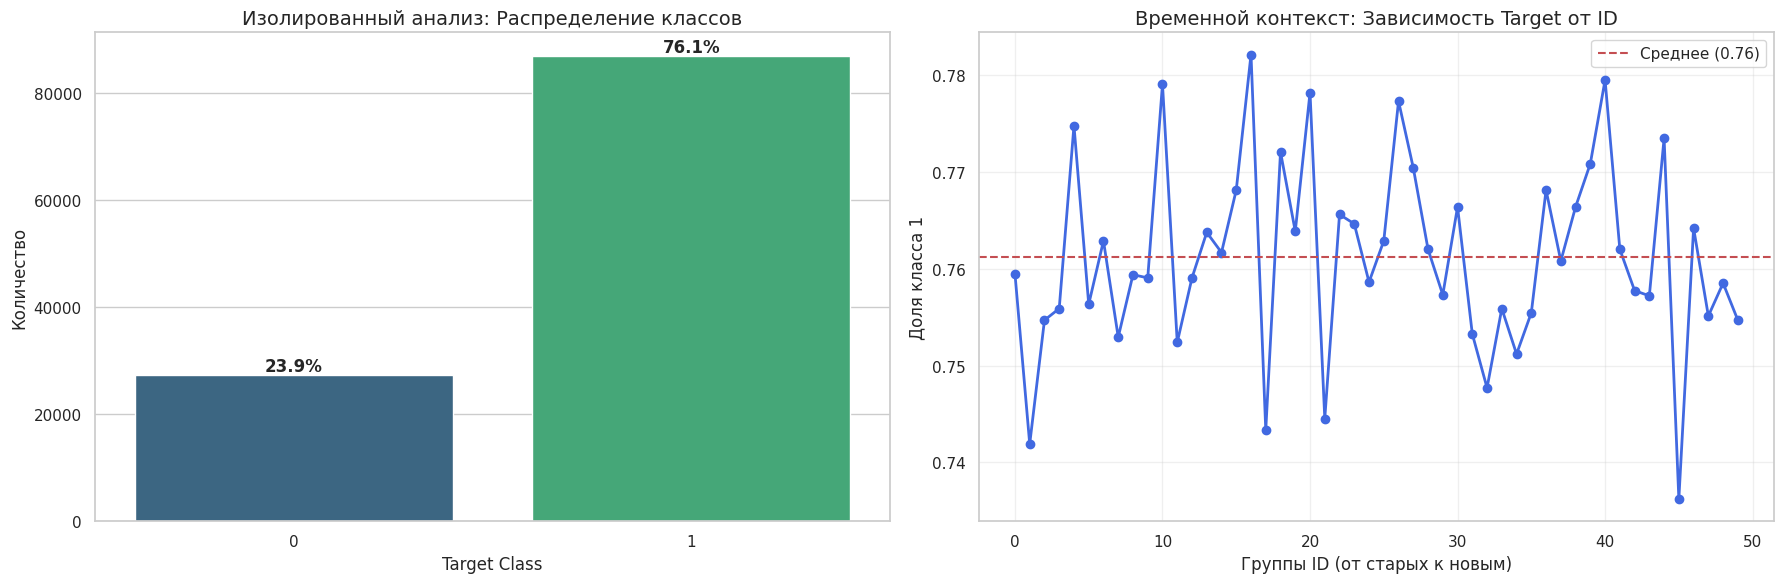

In [4]:
def print_target_statistics(df: pd.DataFrame, target_col: str) -> None:
    """Выводит численные статистики и проверяет баланс классов."""
    counts = df[target_col].value_counts()
    percs = df[target_col].value_counts(normalize=True)
    
    print(f"=== Статистика по '{target_col}' ===")
    print(f"Всего наблюдений: {len(df)}")
    print(f"Класс 0: {counts.get(0, 0)} ({percs.get(0, 0):.2%})")
    print(f"Класс 1: {counts.get(1, 0)} ({percs.get(1, 0):.2%})")
    
    if 0.45 < percs.get(1, 0) < 0.55:
        print(">> Вывод: Классы сбалансированы.")
    else:
        print(">> Вывод: Наблюдается дисбаланс классов.")
    print("-" * 30)

def plot_target_distribution(df: pd.DataFrame, ax: plt.Axes, target_col: str) -> None:
    """Строит countplot для изолированного анализа распределения."""
    sns.countplot(
        x=target_col,
        hue=target_col,
        data=df,
        ax=ax,
        palette='viridis',
        legend=False
    )


    ax.set_title('Изолированный анализ: Распределение классов', fontsize=14)
    ax.set_xlabel('Target Class')
    ax.set_ylabel('Количество')
    
    # Аннотации с процентами
    total = len(df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

def plot_target_drift(df: pd.DataFrame, ax: plt.Axes, target_col: str, id_col: str) -> None:
    """Строит график зависимости среднего таргета от ID (анализ временного контекста)."""
    if id_col not in df.columns:
        ax.text(0.5, 0.5, f'Колонка {id_col} не найдена', ha='center', fontsize=14)
        return

    # Биннинг по ID для сглаживания тренда
    df_sorted = df.sort_values(id_col).copy()
    df_sorted['id_group'] = pd.qcut(df_sorted[id_col], q=50, labels=False)
    
    drift_data = df_sorted.groupby('id_group')[target_col].mean()
    global_mean = df[target_col].mean()
    
    ax.plot(drift_data.index, drift_data.values, marker='o', linestyle='-', color='royalblue', linewidth=2)
    ax.axhline(y=global_mean, color='r', linestyle='--', label=f'Среднее ({global_mean:.2f})')
    
    ax.set_title('Временной контекст: Зависимость Target от ID', fontsize=14)
    ax.set_xlabel('Группы ID (от старых к новым)')
    ax.set_ylabel('Доля класса 1')
    ax.legend()
    ax.grid(True, alpha=0.3)

def analyze_target_full(df: pd.DataFrame, target_col: str = 'target', id_col: str = 'ID') -> None:
    """
    Главная функция-оркестратор для анализа целевой переменной.
    Вызывает функции статистики и визуализации.
    """
    # 1. Численный анализ
    print_target_statistics(df, target_col)
    
    # 2. Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    plot_target_distribution(df, axes[0], target_col)
    plot_target_drift(df, axes[1], target_col, id_col)
    
    plt.tight_layout()
    plt.show()

# Запуск
analyze_target_full(train_df)

### Выводы по анализу целевой переменной

На основе проведенного визуального и численного анализа можно сделать следующие выводы, определяющие стратегию валидации:

1.  **Дисбаланс классов:**
    *   Наблюдается перевес в сторону класса 1 (**76.1%**) против класса 0 (**23.9%**).
    *   **Решение:** При построении валидации будем использовать **Stratified Sampling** (стратифицированную выборку), чтобы сохранить пропорции классов в каждом фолде. Это критично для корректной оценки модели.

2.  **Отсутствие временного дрифта:**
    *   График зависимости среднего таргета от `ID` демонстрирует хаотичные колебания вокруг глобального среднего (0.76) без выраженного восходящего или нисходящего тренда.
    *   Это указывает на то, что данные однородны и, вероятно, были предварительно перемешаны организаторами, либо `ID` не несет временной информации.
    *   **Решение:** Нет необходимости использовать TimeSeriesSplit. Мы можем использовать **Random Shuffle** при кросс-валидации, так как риск "заглядывания в будущее" отсутствует.

**Итоговая стратегия валидации:** StratifiedKFold (5 фолдов) с перемешиванием (Shuffle).

### Анализ признаков

Для систематизации EDA реализован класс `FeatureAnalyzer`.

**Ключевые направления анализа:**

1.  **Пропущенные значения:** Оценка масштаба разреженности данных. Помогает выбрать стратегию импутации.
2.  **Мультиколлинеарность:** Поиск избыточных признаков (с корреляцией > 0.95), которые могут вносить шум и замедлять обучение.
3.  **Важность признаков:** Оценка линейной связи числовых переменных с целевой. Позволяет выделить топ-драйверы.
4.  **Распределения:** Поиск аномалий, выбросов и смещения в предполагаемых ключевых признаках.
5.  **Категориальные признаки:** Анализ кардинальности. Выявление признаков с большим количеством уникальных значений для выбора метода кодирования.
6.  **Анализ строк (Row-wise stats):** Проверка гипотезы: *«Коррелирует ли количество пропусков в строке с целевой переменной?»* (частая "золотая фича" в задачах со страховыми данными).

Инициализация анализатора: 131 признаков (112 числовых, 19 категориальных).
Всего колонок с пропусками: 119
Колонок с >50% пропусков: 1

Топ-10 колонок по пропускам (%):
v30     52.580016
v113    48.376064
v102    44.887641
v85     44.333062
v119    44.331313
v123    44.329563
v51     44.329563
v23     44.326939
v115    43.644650
v69     43.644650
dtype: float64


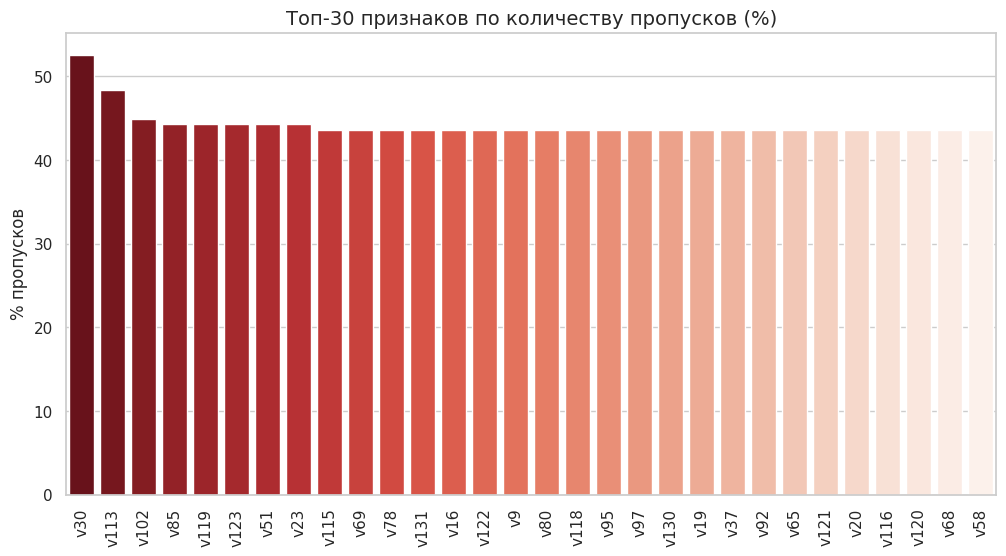

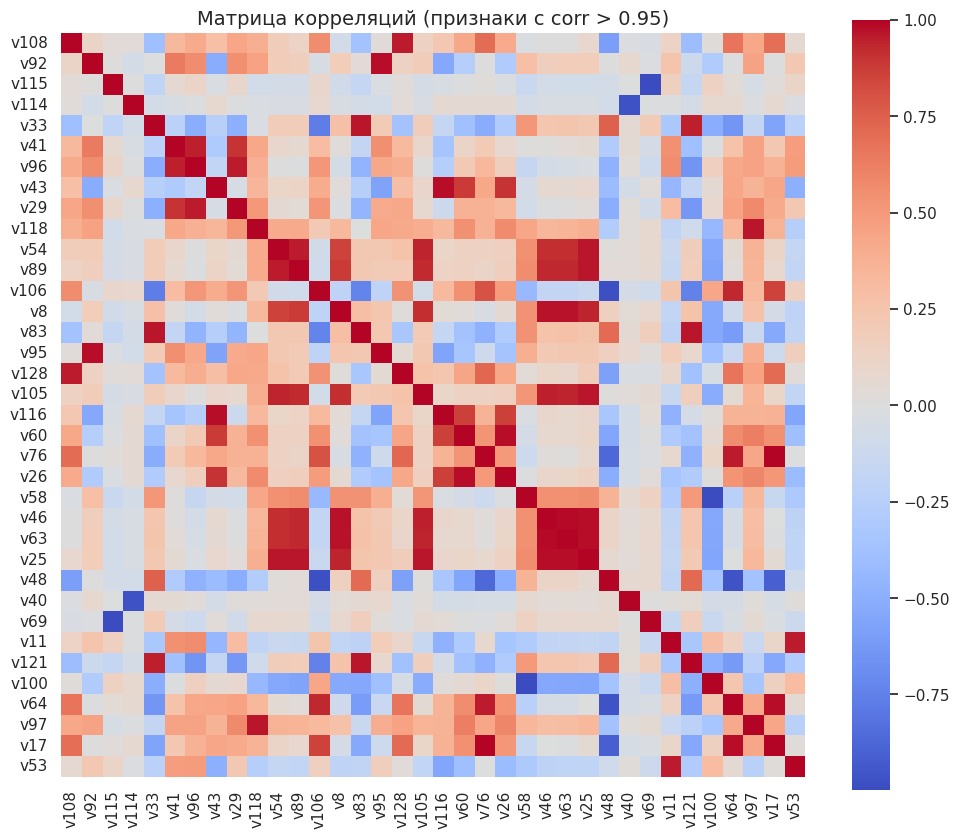

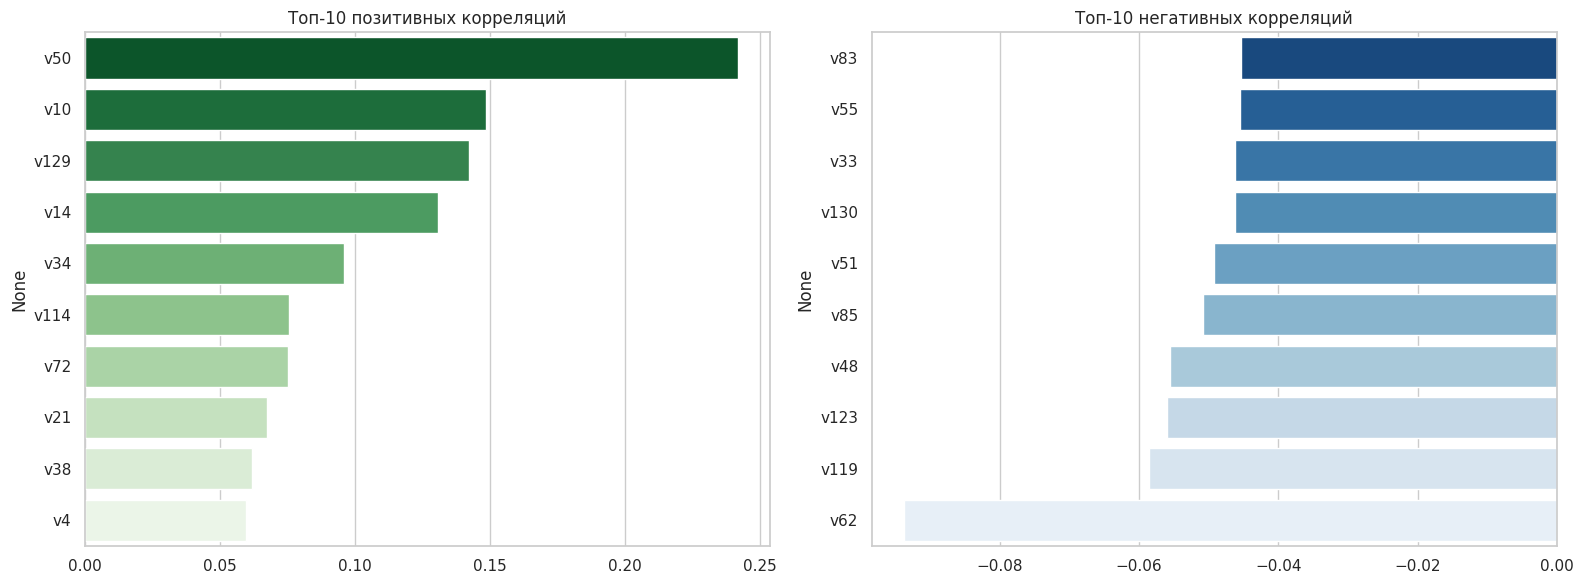

Детальный анализ топ-3 признаков: ['v50', 'v10', 'v129']


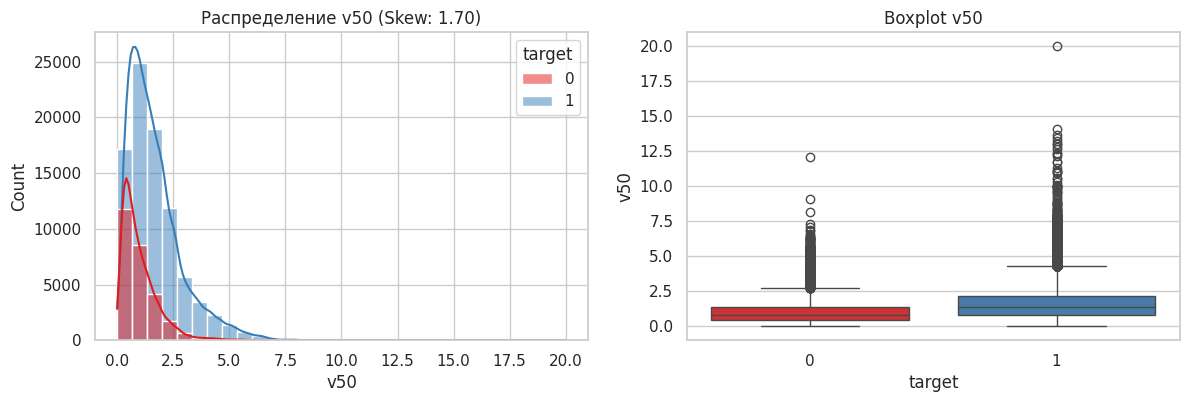

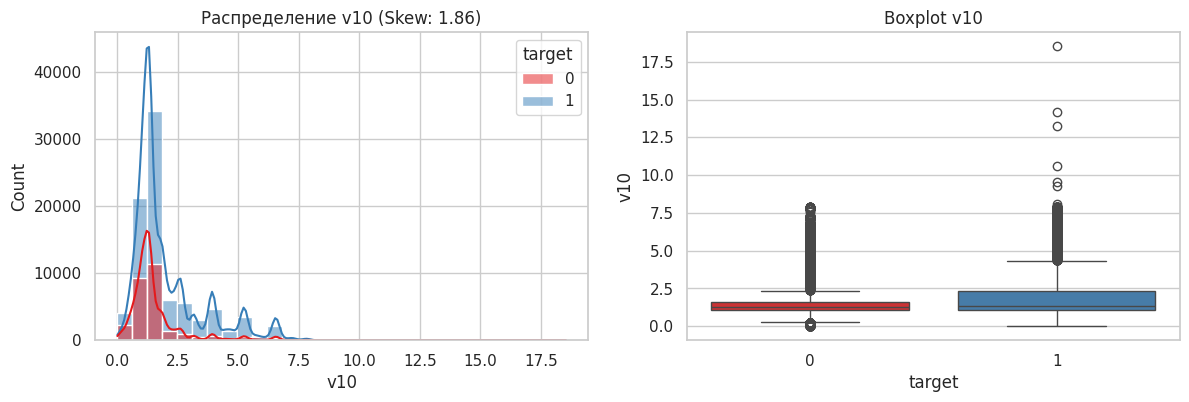

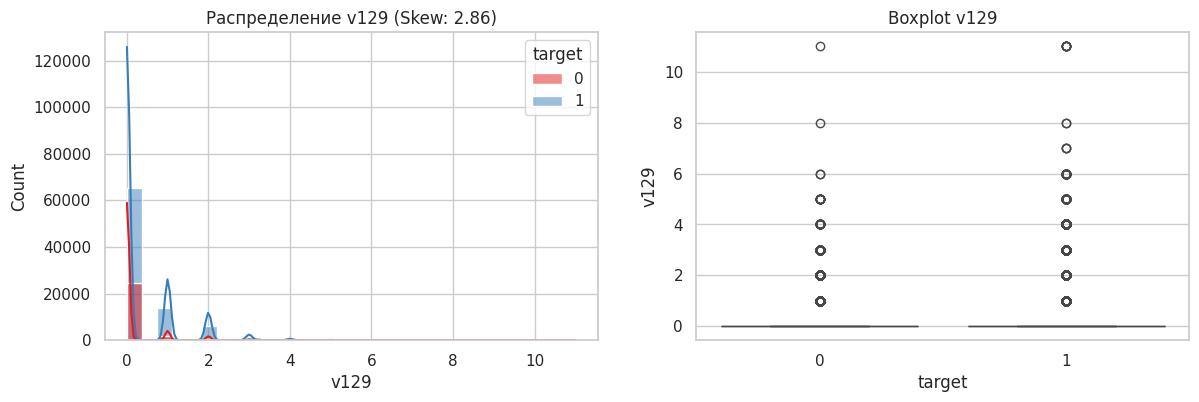

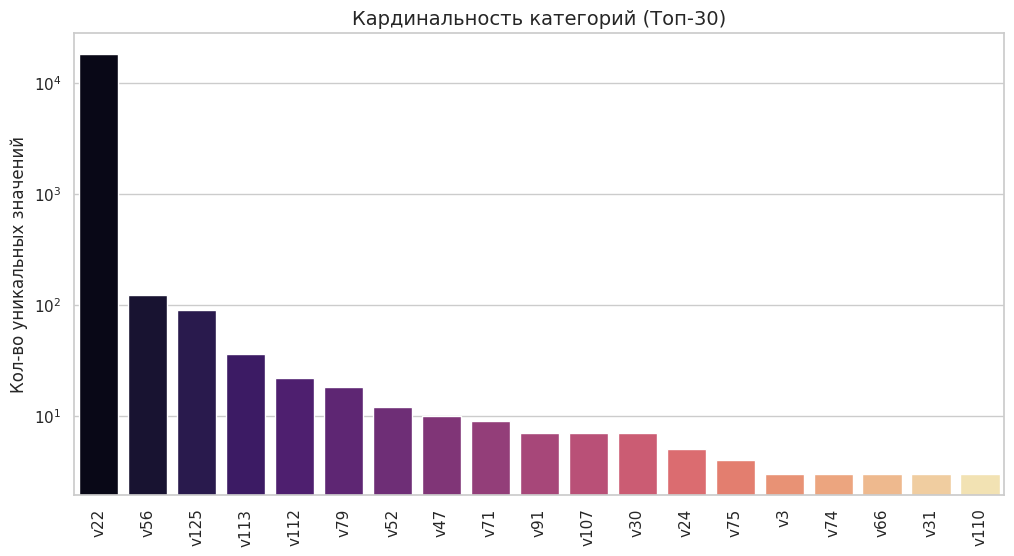

Признаки с высокой кардинальностью (>100): ['v22', 'v56']


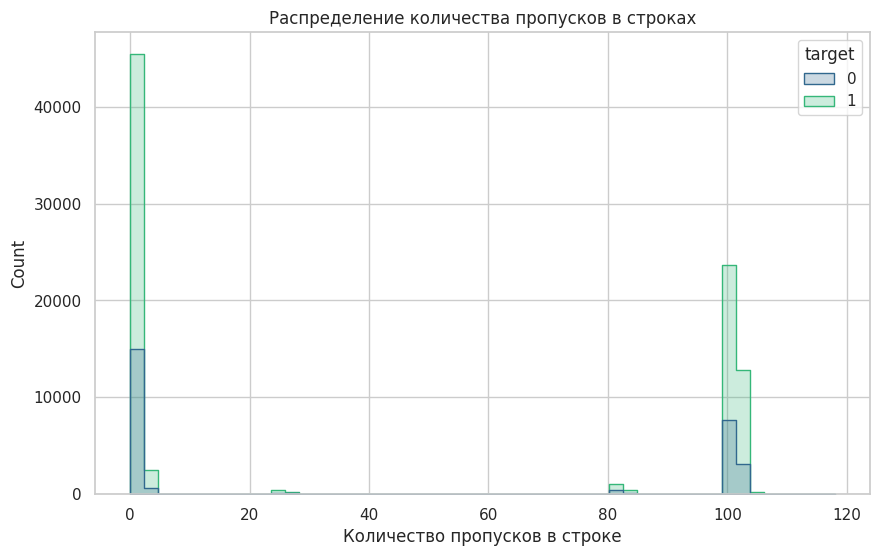

In [5]:
class FeatureAnalyzer:
    def __init__(self, df: pd.DataFrame, target_col: str = 'target', id_col: str = 'ID'):
        self.df = df.copy()
        self.target_col = target_col
        self.id_col = id_col
        
        self.cols_all = [c for c in df.columns if c not in [target_col, id_col]]
        self.cols_num = df[self.cols_all].select_dtypes(include=[np.number]).columns.tolist()
        self.cols_cat = df[self.cols_all].select_dtypes(exclude=[np.number]).columns.tolist()
        
        print(f"Инициализация анализатора: {len(self.cols_all)} признаков "
              f"({len(self.cols_num)} числовых, {len(self.cols_cat)} категориальных).")

    def _plot_barplot(self, data: pd.Series, title: str, xlabel: str = '', ylabel: str = '', 
                      color: str = 'viridis', rotation: int = 90, log_scale: bool = False):
        """Вспомогательный метод с поддержкой логарифмической шкалы."""
        plt.figure(figsize=(12, 6))
        
        sns.barplot(x=data.index, y=data.values, hue=data.index, palette=color, legend=False)
        
        plt.xticks(rotation=rotation)
        plt.title(title, fontsize=14)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        if log_scale:
            plt.yscale('log')
            
        plt.show()


    def report_missing_values(self, top_n: int = 30):
        """1. Анализ пропусков: статистика + график."""
        missing = self.df[self.cols_all].isnull().mean().sort_values(ascending=False) * 100
        missing = missing[missing > 0]
        
        if missing.empty:
            print("Пропусков в данных нет.")
            return

        print(f"Всего колонок с пропусками: {len(missing)}")
        print(f"Колонок с >50% пропусков: {len(missing[missing > 50])}")
        print("\nТоп-10 колонок по пропускам (%):")
        print(missing.head(10))

        self._plot_barplot(
            missing.head(top_n), 
            title=f'Топ-{top_n} признаков по количеству пропусков (%)',
            ylabel='% пропусков',
            color='Reds_r'
        )

    def report_correlations(self, threshold: float = 0.9):
        """2. Анализ корреляций: фильтрация сильных связей."""
        if not self.cols_num:
            print("Нет числовых признаков для анализа корреляций.")
            return

        corr_matrix = self.df[self.cols_num].corr().abs()
        
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_corr_cols = [col for col in upper.columns if any(upper[col] > threshold)]
        
        if not high_corr_cols:
            print(f"Нет признаков с корреляцией выше {threshold}")

            self._plot_heatmap(corr_matrix.iloc[:20, :20], "Фрагмент матрицы корреляций (первые 20 признаков)")
            return

        subset_cols = set(high_corr_cols)
        for col in high_corr_cols:
            subset_cols.update(upper.index[upper[col] > threshold].tolist())
        
        subset_df = self.df[list(subset_cols)].corr()
        self._plot_heatmap(subset_df, f'Матрица корреляций (признаки с corr > {threshold})')

    def _plot_heatmap(self, corr_data: pd.DataFrame, title: str):
        """Вспомогательный метод для хитмапа."""
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_data, annot=False, cmap='coolwarm', center=0, square=True)
        plt.title(title, fontsize=14)
        plt.show()

    def report_target_correlations(self, top_n: int = 10):
        """3. Важность признаков: корреляция с таргетом."""
        if not self.cols_num:
            return

        corrs = self.df[self.cols_num].corrwith(self.df[self.target_col]).sort_values(ascending=False)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        head_data = corrs.head(top_n)
        sns.barplot(x=head_data.values, y=head_data.index, hue=head_data.index, 
                    ax=axes[0], palette='Greens_r', legend=False)
        axes[0].set_title(f'Топ-{top_n} позитивных корреляций')
        
        tail_data = corrs.tail(top_n)
        sns.barplot(x=tail_data.values, y=tail_data.index, hue=tail_data.index, 
                    ax=axes[1], palette='Blues_r', legend=False)
        axes[1].set_title(f'Топ-{top_n} негативных корреляций')
        
        plt.tight_layout()
        plt.show()
        
        return corrs

    def report_distributions(self, features: List[str]):
        """4. Детальный анализ распределений конкретных признаков."""
        valid_features = [f for f in features if f in self.cols_num]
        
        if not valid_features:
            print("Не переданы валидные числовые признаки.")
            return

        for feat in valid_features:
            fig, axes = plt.subplots(1, 2, figsize=(14, 4))
            
            sns.histplot(data=self.df, x=feat, hue=self.target_col, kde=True, 
                         ax=axes[0], palette='Set1', bins=30, common_norm=False)
            axes[0].set_title(f'Распределение {feat} (Skew: {self.df[feat].skew():.2f})')
 
            sns.boxplot(x=self.target_col, y=feat, hue=self.target_col, 
                        data=self.df, ax=axes[1], palette='Set1', legend=False)
            axes[1].set_title(f'Boxplot {feat}')
            
            plt.show()

    def report_categorical(self, top_n: int = 30):
        """5. Анализ кардинальности категорий."""
        if not self.cols_cat:
            print("Нет категориальных признаков.")
            return

        unique_counts = self.df[self.cols_cat].nunique().sort_values(ascending=False)
        
        self._plot_barplot(
            unique_counts.head(top_n),
            title=f'Кардинальность категорий (Топ-{top_n})',
            ylabel='Кол-во уникальных значений',
            color='magma',
            log_scale=True 
        )
        
        high_card = unique_counts[unique_counts > 100]
        if not high_card.empty:
            print(f"Признаки с высокой кардинальностью (>100): {list(high_card.index)}")

    def report_row_nan_stats(self):
        """6. Анализ пропусков по строкам."""
        nan_counts = self.df.isnull().sum(axis=1)
        
        plt.figure(figsize=(10, 6))
        sns.histplot(x=nan_counts, hue=self.df[self.target_col], bins=50, kde=False, palette='viridis', element="step")
        plt.title("Распределение количества пропусков в строках")
        plt.xlabel("Количество пропусков в строке")
        plt.show()




analyzer = FeatureAnalyzer(train_df)

# 1. Пропуски
analyzer.report_missing_values()

# 2. Корреляции (только сильные)
analyzer.report_correlations(threshold=0.95)

# 3. Важность признаков + получение списка
target_corrs = analyzer.report_target_correlations()

# 4. Анализ топ-3 признаков (автоматически берем самые важные)
if target_corrs is not None:
    top_features = target_corrs.abs().sort_values(ascending=False).head(3).index.tolist()
    print(f"Детальный анализ топ-3 признаков: {top_features}")
    analyzer.report_distributions(top_features)

# 5. Категории
analyzer.report_categorical()

# 6. Пропуски в строках
analyzer.report_row_nan_stats()

### Выводы по анализу признаков

Проведенный анализ выявил сложную структуру данных, что диктует конкретные требования к пайплайну предобработки:

1.  **Пропущенные значения (Sparsity):**
    *   Данные сильно разрежены: **119 из 131** признаков содержат пропуски.
    *   Топ-признаки (`v30`, `v113`) отсутствуют почти в половине случаев.
    *   **Инсайт (Row-wise NaNs):** График *«Распределение количества пропусков в строках»* показывает четкую сегментацию. Наблюдаются кластеры строк с малым (0-5) и большим (~100) количеством пропусков, причем распределение таргета внутри этих кластеров различается.
    *   **Решение:** Попробовать сгенерировать признак `nan_count` (количество пропусков в строке), так как, кажется, он несет сигнал. Использовать модели, умеющие нативно работать с `NaN` (XGBoost/LGBM/CatBoost).

2.  **Мультиколлинеарность:**
    *   Heatmap показывает наличие "кластеров" признаков с корреляцией **>0.95**.
    *   **Решение:** Для линейных моделей это критично, для деревьев - избыточно. В пайплайне имеет смысл удалить один из пары признаков с корреляцией близкой к 1.0, чтобы снизить размерность и ускорить обучение.

3.  **Категориальные признаки (High Cardinality):**
    *   Признак **`v22`** является аномальным по кардинальности (тысячи категорий), в то время как большинство остальных имеют <100 уникальных значений.
    *   **Решение:** Можно попробовать применить Count Encoding или Target Encoding именно для этого признака. Также `v22` - главный кандидат для поиска взаимодействий (Feature Interactions).

4.  **Распределения числовых признаков:**
    *   Топ-коррелирующие признаки (`v50`, `v10`, `v129`) имеют сильное смещение (Skewness > 1.5) и тяжелые хвосты (выбросы).
    *   **Решение:** Модели, основанные на деревьях, устойчивы к выбросам и не требуют логарифмирования, поэтому мой выбор склоняется в пользу использования градиентного бустинга в качестве основной модели.

# Моделирование

### Настройка системы оценки (Evaluation Framework)

Для систематического отслеживания прогресса экспериментов реализуем локальный лидерборд.

*   **`LOG_LOSS_SCORES`**: Словарь-реестр для накопления результатов всех моделей.
*   **`update_leaderboard`**: Функция-хелпер, которая после каждого эксперимента сравнивает полученную метрику с лучшим результатом (Current Best) и визуализирует улучшение (или отставание), позволяя сразу оценивать эффективность изменений в пайплайне.

In [6]:
LOG_LOSS_SCORES = {} # Будем хранить скоры всех результатов тут

def update_leaderboard(model_key, current_score, scores_dict):
    """
    Сравнивает текущий скор с лучшим результатом в лидерборде,
    выводит отчет и обновляет словарь.
    """

    if not scores_dict:
        prev_best_name = "None"
        prev_best_score = float('inf')
    else:
        prev_best_name = min(scores_dict, key=scores_dict.get)
        prev_best_score = scores_dict[prev_best_name]

    print(f"\n{'='*10} EVALUATION REPORT: {model_key} {'='*10}")
    print(f"Current LogLoss:  {current_score:.5f}")
    
    if current_score < prev_best_score:
        improvement = prev_best_score - current_score
        print(f"Previous Best:    {prev_best_score:.5f} ({prev_best_name})")
        print(f"Improvement:      \033[92m-{improvement:.5f}\033[0m")
        print(f"Status:           🏆 SUCCESS")
    else:
        gap = current_score - prev_best_score
        print(f"Current Leader:   {prev_best_score:.5f} ({prev_best_name})")
        print(f"Gap to Leader:    +{gap:.5f}")
        print(f"Status:           ⚠️ NO IMPROVEMENT")
    
    print("="*45 + "\n")
    
    scores_dict[model_key] = current_score

# LAMA Baseline (2 конфигурации)

### Конфигурация 1: General

**Стратегия:**
Запуск `TabularAutoML` с щедрым лимитом времени (**3600 секунд**).
Это позволяет AutoML-движку:
1.  Задействовать полный спектр алгоритмов.
2.  Провести глубокую настройку гиперпараметров.
3.  Построить сложный многоуровневый ансамбль.

**Цель:** Получить насколько возможно качественный бейзлайн («потолок» автоматического решения), который станет основным ориентиром для сравнения с кастомным пайплайном.

In [7]:
task = Task('binary', metric='logloss')
roles = {
    'target': 'target'
}

automl = TabularAutoML(
    task=task,
    timeout=3600,
    reader_params={'random_state': SEED}
)

oof_pred = automl.fit_predict(train_df, roles=roles, verbose=1)


# Предсказания LAMA возвращает в формате вероятностей (вероятность класса 1)
# oof_pred.data[:, 0] - это вероятности

# Считаем метрику на трейне (Out-of-Fold)
lama_score = log_loss(train_df['target'], oof_pred.data[:, 0])
print(f"LAMA LogLoss (OOF): {lama_score:.5f}")

test_pred = automl.predict(test_df)
submission = pd.DataFrame({
    'ID': test_id,
    'PredictedProb': test_pred.data[:, 0]
})
filename = 'lama_baseline_general_submission.csv'
submission.to_csv(filename, index=False)

update_leaderboard('lama_general', lama_score, LOG_LOSS_SCORES)

[13:29:27] Stdout logging level is INFO.
[13:29:27] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[13:29:27] Task: binary

[13:29:27] Start automl preset with listed constraints:
[13:29:27] - time: 3600.00 seconds
[13:29:27] - CPU: 4 cores
[13:29:27] - memory: 16 GB

[13:29:27] Train data shape: (114321, 133)

[13:29:38] Layer 1 train process start. Time left 3589.36 secs
[13:29:42] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:30:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.4830211798376593
[13:30:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[13:30:05] Time left 3562.73 secs

[13:30:21] Selector_LightGBM fitting and predicting completed
[13:30:26] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[13:31:33] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.4799254177794844
[13:31:33] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[13:31:33] Start hyperparameters optimization f

Optimization Progress:  15%|█▍        | 15/101 [05:13<29:57, 20.90s/it, best_trial=6, best_value=-0.48]

[13:36:47] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[13:36:47] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[13:37:44] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.479532920698948
[13:37:44] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[13:37:44] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[13:38:49] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.4823376627966618
[13:38:49] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[13:38:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  20%|█▉        | 20/101 [05:16<21:23, 15.85s/it, best_trial=13, best_value=-0.483]

[13:44:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[13:44:06] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[13:46:01] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.4813661226512457
[13:46:01] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[13:46:01] Time left 2606.45 secs

[13:46:01] Layer 1 training completed.

[13:46:01] Blending: optimization starts with equal weights. Score = -0.4766718
[13:46:01] Blending: iteration 0: score = -0.4752899, weights = [0.35316363 0.34929928 0.29753706 0.         0.        ]
[13:46:02] Blending: iteration 1: score = -0.4752599, weights = [0.38329265 0.3054543  0.3112531  0.         0.        ]
[13:46:03] Blending: iteration 2: score = -0.4752592, weights = [0.38591075 0.29695252 0.31713673 0.         0.        ]
[13:46:03] Blending: no improvements for score. Terminated.

[13:46:03] Blending: best score = -0.4752592, best weights = [0.38591075 0.29695252 0.31713673 0.         0.        ]
[13:46:03] Automl preset training completed in 995.79 seconds

[13:46:03] Model description:
Final prediction for new objects (level 0

### Конфигурация: Fast

**Стратегия:**
Запуск с жестким ограничением ресурсов для проверки гипотезы о «быстрой сходимости»:
1.  **Time Limit:** 600 секунд (10 минут).
2.  **Алгоритмы:** Ограничение пространства поиска только градиентным бустингом (`LightGBM` и `CatBoost`), исключая линейные модели для экономии времени.
3.  **Валидация:** Явное задание 5-фолдовой кросс-валидации.

**Цель:** Оценить trade-off между временем обучения и точностью. Понять, какой прирост качества дает «тяжелый» ансамбль по сравнению с быстрым бустингом.

In [8]:
task = Task('binary', metric='logloss')

roles = {
    'target': 'target',
    'drop': ['ID']
}

automl = TabularAutoML(
    task=task,
    timeout=600,
    cpu_limit=-1,
    general_params={
        'use_algos': [['lgb', 'cb']] # Используем LightGBM и CatBoost
    },
    reader_params={
        'cv': 5,            # 5 фолдов кросс-валидации
        'random_state': SEED
    },
)

oof_pred = automl.fit_predict(train_df, roles=roles, verbose=1)


lama_score = log_loss(train_df['target'], oof_pred.data[:, 0])
print(f"LAMA LogLoss (OOF): {lama_score:.5f}")

test_pred = automl.predict(test_df)
submission = pd.DataFrame({
    'ID': test_id,
    'PredictedProb': test_pred.data[:, 0]
})
filename = 'lama_baseline_specific_submission.csv'
submission.to_csv(filename, index=False)

update_leaderboard('lama_fast', lama_score, LOG_LOSS_SCORES)

[13:46:14] Stdout logging level is INFO.
[13:46:14] Task: binary

[13:46:14] Start automl preset with listed constraints:
[13:46:14] - time: 600.00 seconds
[13:46:14] - CPU: 6 cores
[13:46:14] - memory: 16 GB

[13:46:14] Train data shape: (114321, 133)

[13:46:23] Layer 1 train process start. Time left 590.81 secs
[13:46:41] Selector_LightGBM fitting and predicting completed
[13:46:45] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[13:47:56] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.4798408492276012
[13:47:56] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[13:47:56] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[13:49:07] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.4821759428297376
[13:49:07] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[13:49:07] Time left 426.74 secs

[13:49:07] Layer 1 training completed.

[13:49:07] Blending: optimization starts with equal weights. Score = -0.4793536
[13:49:08] Blending: iteration 0: score 

### Результаты экспериментов (заполняется после запуска)

| Конфигурация | Time limit | Алгоритмы | OOF LogLoss | Комментарий |
|---|---|---|---|---|
| **Config 1** | 3600 sec | Auto (All) | **0.47526** | Лучший результат, построен сложный блендинг. |
| **Config 2** | 600 sec | LGBM + CatBoost | 0.47914 | Работает быстрее, но уступает по качеству. |

**Вывод:**
Лучший результат показала **Конфигурация 1** (0.47526). Именно это значение мы будем стараться превзойти в собственном решении (Custom Pipeline).

# Собственное решение

### Feature Engineering

Реализуем кастомный класс-трансформер `FeatureEngineer`. Он будет решать задачи, выявленные на этапе EDA:

1.  **Новые признаки:** Добавляем `nan_count` (количество пропусков) — на этапе анализа мы видели, что это сильный сигнал. Заодно посчитаем количество нулей (`zeros_count`).
2.  **Чистка корреляций:** Чтобы не перегружать модель дублирующей информацией, автоматически отсеем один из признаков в парах с корреляцией выше **0.98**.

In [9]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, high_card_cols=['v22'], drop_high_corr=True):
        self.high_card_cols = high_card_cols
        self.drop_high_corr = drop_high_corr
        self.corr_cols_to_drop_ = []
    
    def fit(self, X, y=None):
        # Если нужно удалять коррелирующие признаки, находим их тут
        if self.drop_high_corr:
            # Считаем на подмножестве для скорости, если данных много
            nums = X.select_dtypes(include=[np.number])
            corr_matrix = nums.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.corr_cols_to_drop_ = [column for column in upper.columns if any(upper[column] > 0.98)]
        return self
    
    def transform(self, X):
        X_ = X.copy()
        
        # 1. Feature: NaN Count (Количество пропусков)
        X_['nan_count'] = X_.isnull().sum(axis=1)
        
        # 2. Feature: Zeros Count (Количество нулей - часто важно)
        X_['zeros_count'] = (X_ == 0).sum(axis=1)
        
        # Удаляем коррелирующие (если обучили)
        if self.corr_cols_to_drop_:
            X_ = X_.drop(columns=self.corr_cols_to_drop_, errors='ignore')
            
        return X_

Подготовка данных перед обучением XGBoost, в частности - корректное кодирование категориальных признаков, заполнение пропусков и разделение числовых/категориальных столбцов.

Я реализовал класс `DataPreprocessor`, который решает две задачи:
1.  **Заполнение пропусков:** Используем стратегию констант (`-999` для чисел, `'Missing'` для категорий). Для деревьев это часто работает лучше среднего, так как позволяет модели выделить пропущенные значения в отдельную ветку - вдруг сам факт пропуска является важным сигналом?
2.  **Кодирование категорий:** Превращаем строки в числа через `OrdinalEncoder`

In [10]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Препроцессор для заполнения пропусков и кодирования категорий.
    Сохраняет исходную структуру DataFrame и имена колонок.
    """
    def __init__(self, cat_fill_value: str = 'Missing', num_fill_value: int = -999):
        self.cat_fill_value = cat_fill_value
        self.num_fill_value = num_fill_value
       
        self.ord_enc = OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=-1, 
            dtype=np.int32
        )
        self.cat_cols: List[str] = []
        self.num_cols: List[str] = []

    def fit(self, X: pd.DataFrame, y=None):
        self.cat_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        
        # Обучаем энкодер только на категориальных колонках
        if self.cat_cols:
            X_cat = X[self.cat_cols].fillna(self.cat_fill_value)
            self.ord_enc.fit(X_cat)
            
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_out = X.copy()
        
        # 1. Числовые: заполняем пропуски (только для существующих колонок)
        curr_num = [c for c in self.num_cols if c in X_out.columns]
        if curr_num:
            X_out[curr_num] = X_out[curr_num].fillna(self.num_fill_value)
        
        # 2. Категориальные: пропуски + кодирование
        curr_cat = [c for c in self.cat_cols if c in X_out.columns]
        if curr_cat:
            X_out[curr_cat] = X_out[curr_cat].fillna(self.cat_fill_value)
            X_out[curr_cat] = self.ord_enc.transform(X_out[curr_cat])
            
        return X_out

train_clean = train_df.drop(['ID', 'target'], axis=1, errors='ignore')
test_clean = test_df.drop(['ID'], axis=1, errors='ignore')


preprocessor = DataPreprocessor()
train_proc = preprocessor.fit_transform(train_clean)
test_proc = preprocessor.transform(test_clean)


# Решение 1: Базовый XGBoost

Начнем с построения собственного пайплайна. В качестве основной модели я выбрал **XGBoost**. Он отлично справляется с табличными данными и устойчив к пропускам.

**Архитектурное решение:**
Я использую **Stratified K-Fold**, чтобы сохранить баланс классов в каждом фолде.

Параметры модели пока беру на мой взгляд стандартные, чтобы получить отправную точку (baseline) для своего решения.

In [11]:
# Настройки кросс-валидации
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Контейнеры для результатов
oof_preds = np.zeros(train_proc.shape[0])
test_preds = np.zeros(test_proc.shape[0])
scores = []

# Определяем модель
model_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'random_state': SEED,
    'eval_metric': 'logloss',
    'early_stopping_rounds': 50
}

X = train_proc.copy()
y = train_df['target']

X_test = test_proc.copy()

print(f"Запуск обучения XGBoost на {folds.n_splits} фолдах...")

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    # 1. Разделяем данные
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # 2. Применяем Feature Engineering (создаем nan_count)
    fe = FeatureEngineer(drop_high_corr=True)
    X_train_eng = fe.fit_transform(X_train)
    X_val_eng = fe.transform(X_val)
    
    if fold == 0:
        X_test_eng = fe.transform(X_test)
    
    # 3. Обучаем модель
    model = XGBClassifier(**model_params)
    
    model.fit(
        X_train_eng, y_train,
        eval_set=[(X_val_eng, y_val)],
        verbose=False 
    )
    
    # 4. Предсказываем
    val_pred = model.predict_proba(X_val_eng)[:, 1]
    
    # Складываем предсказания для теста
    test_preds += model.predict_proba(X_test_eng)[:, 1] / folds.n_splits
    
    # Сохраняем OOF
    oof_preds[val_idx] = val_pred
    
    # Считаем скор
    score = log_loss(y_val, val_pred)
    scores.append(score)
    print(f"Fold {fold+1} LogLoss: {score:.5f}")

print("-" * 30)
mean_score = np.mean(scores)
print(f"XGB V1 Score:  {mean_score:.5f}")


sub = pd.DataFrame({
    'ID': test_id,
    'PredictedProb': test_preds
})
sub.to_csv('solution_v1_submission.csv', index=False)

update_leaderboard('xgb_v1_base', mean_score, LOG_LOSS_SCORES)

Запуск обучения XGBoost на 5 фолдах...
Fold 1 LogLoss: 0.48191
Fold 2 LogLoss: 0.47469
Fold 3 LogLoss: 0.47861
Fold 4 LogLoss: 0.47870
Fold 5 LogLoss: 0.47627
------------------------------
XGB V1 Score:  0.47804

========== EVALUATION REPORT: xgb_v1_base ==========
Current LogLoss:  0.47804
Current Leader:   0.47526 (lama_general)
Gap to Leader:    +0.00278
Status:           ⚠️ NO IMPROVEMENT



### Анализ результатов V1

Первая попытка дала **0.47804**, что пока уступает мощному бейзлайну LAMA (+0.0028). Это ожидаемо: мы использовали одиночную модель против ансамбля, да и гиперпараметры брали «на глаз».

Однако результат позитивный: кросс-валидация ведет себя стабильно, сильных провалов по фолдам нет.

**Гипотеза улучшения:**
В EDA мы заметили, что признак `v22` имеет огромную кардинальность. Сейчас мы кодируем его простым `OrdinalEncoder` (просто присваиваем случайные числа категориям). Для деревьев это сложно — им приходится делать много сплитов, чтобы выучить зависимость.
**План:** В следующей итерации применим **Count Encoding** (частотное кодирование) для `v22`. Это должно дать модели явный сигнал о популярности категорий и упростить обучение.

### Решение 2: Работа с признаками

Проверяем гипотезы, которые мы сформулировали на этапе EDA. Простого `Ordinal Encoding` для таких сложных данных недостаточно, поэтому усиливаем подачу информации модели:

1.  **Count Encoding для `v22`**: Так как `v22` имеет аномально высокую кардинальность, заменим категории на частоту их встречаемости. Это поможет дереву решений быстрее находить значимые разбиения, ориентируясь на популярность категории, а не на случайный порядковый номер.
2.  **`nan_count`**: Явно добавляем количество пропусков в строке как отдельную фичу (инсайт из анализа строк).
3.  **Тюнинг**: Немного "замедлим" обучение (`learning_rate` снижен до 0.02, деревьев добавлено до 1200), чтобы модель успела качественнее обработать новые закономерности.

In [12]:
# Версия 2: Count Encoding

# 1. Подготовка базовых данных
X = train_proc.copy()
y = train_df['target']

X_test = test_proc.copy()

# 2. Генерация "Козырных" фичей
fe = FeatureEngineer(drop_high_corr=False)

# А) Количество пропусков
# Берем из исходных train_df/test_df, где пропуски еще не заполнены
X_features = fe.fit_transform(train_df)[['nan_count']]
X_test_features = fe.transform(test_df)[['nan_count']]

X = pd.concat([X, X_features], axis=1)
X_test = pd.concat([X_test, X_test_features], axis=1)

# Б) Count Encoding для v22
v22_counts = X['v22'].value_counts().to_dict()
X['v22_count'] = X['v22'].map(v22_counts)
X_test['v22_count'] = X_test['v22'].map(v22_counts).fillna(0)


print(f"Признаков для обучения: {X.shape[1]}")

# 3. Настройка XGBoost
xgb_params = {
    'n_estimators': 1200,      
    'learning_rate': 0.02,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,    
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'random_state': SEED,
    'eval_metric': 'logloss',
    'early_stopping_rounds': 50
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros(X_test.shape[0])
scores = []

print("Запуск V2 (Full Features + nan_count + v22_count)...")

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**xgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    
    # Накапливаем предсказания для теста
    test_preds += model.predict_proba(X_test)[:, 1] / folds.n_splits
    
    # Сохраняем OOF
    oof_preds[val_idx] = val_pred
    
    score = log_loss(y_val, val_pred)
    scores.append(score)
    print(f"Fold {fold+1} LogLoss: {score:.5f}")

print("-" * 30)
mean_score = np.mean(scores)
print(f"XGB V2 Score:  {mean_score:.5f}")

sub = pd.DataFrame({'ID': test_id, 'PredictedProb': test_preds})
sub.to_csv('solution_v2_submission.csv', index=False)

update_leaderboard('xgb_v2_counts', mean_score, LOG_LOSS_SCORES)

Признаков для обучения: 133
Запуск V2 (Full Features + nan_count + v22_count)...
Fold 1 LogLoss: 0.46548
Fold 2 LogLoss: 0.46055
Fold 3 LogLoss: 0.46233
Fold 4 LogLoss: 0.46188
Fold 5 LogLoss: 0.46202
------------------------------
XGB V2 Score:  0.46245

========== EVALUATION REPORT: xgb_v2_counts ==========
Current LogLoss:  0.46245
Previous Best:    0.47526 (lama_general)
Improvement:      -0.01280
Status:           🏆 SUCCESS



### Анализ результатов V2

**🏆 Цель достигнута!**
Мы не просто побили бейзлайн LAMA (`0.47526`), но и улучшили результат значительно — до **0.46245** (прирост >0.01 LogLoss, что для соревнований очень много).

**Почему это сработало:**
1.  Гипотеза о важности **`nan_count`** подтвердилась: структура пропусков в этих данных несет огромный информационный сигнал.
2.  **Count Encoding** для `v22` сработал лучше, чем `Ordinal Encoding` и методы LAMA по умолчанию.

**Что дальше?**
Раз признак `v22` является таким мощным драйвером, попробуем углубиться. Возможно, скрытая информация лежит не просто в самой категории `v22`, а в её **взаимодействии** с другими переменными. В следующей версии (V2.1) попробуем автоматически найти лучшие пары для `v22` и создать на их основе новые признаки.

## Решение 2.1

### Гипотеза и автоматический отбор признаков (Feature Interaction)

#### Наблюдение:
В ходе EDA было замечено, что признак v22 обладает аномально высокой кардинальностью (тысячи уникальных категорий), в то время как большинство других категориальных признаков имеют мало значений.
#### Гипотеза:
v22 может содержать "скрытую" структуру, которая лучше раскрывается в комбинации с другими категориальными признаками.
Мы попробуем сгенерировать парные взаимодействия (v22 + другой_признак) и проверить, увеличивается ли при этом Mutual Information (Взаимная информация) с целевой переменной.
### Методика:
1. Берем v22 как основу.
2. Проходим циклом по всем остальным категориальным признакам.
3. Создаем временный признак-связку (concatenation).
4. Оцениваем информативность связки через mutual_info_classif.
5. Отбираем Топ N (я взял 7) признаков, которые дают наибольший прирост информации.

In [13]:
def find_best_interactions(df, target_col, main_cat_col='v22', top_n=7):
    """
    Автоматический поиск лучших признаков для взаимодействия с main_cat_col.
    Использует Mutual Information для оценки прироста информации.
    """
    print(f"Поиск лучших взаимодействий для {main_cat_col} ---")
    
    cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != target_col and c != main_cat_col]
    
    sample_df = df.sample(min(20000, len(df)), random_state=42).copy()
    y_sample = sample_df[target_col]
    
    results = []
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        base_col_encoded = pd.factorize(sample_df[main_cat_col])[0]
        base_mi = mutual_info_classif(
            base_col_encoded.reshape(-1, 1), 
            y_sample, 
            discrete_features=True, 
            random_state=42
        )[0]
        
    print(f"Базовый MI для {main_cat_col}: {base_mi:.4f}")
    
    # Перебор кандидатов
    for col in cat_cols:
        # Создаем взаимодействие
        interaction = sample_df[main_cat_col].astype(str) + "_" + sample_df[col].astype(str)
        
        # Кодируем (Label Encoding)
        interaction_encoded = pd.factorize(interaction)[0]
        
        # Считаем MI, подавляя предупреждения
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            mi_score = mutual_info_classif(
                interaction_encoded.reshape(-1, 1), 
                y_sample, 
                discrete_features=True, 
                random_state=42
            )[0]
        
        # Считаем прирост
        gain = mi_score - base_mi
        
        results.append({
            'col': col,
            'mi_score': mi_score,
            'gain': gain
        })
    
    results_df = pd.DataFrame(results).sort_values(by='mi_score', ascending=False)
    
    print("\nТоп найденных кандидатов:")
    display(results_df.head(top_n))
    
    best_cols = results_df.head(top_n)['col'].tolist()
    return best_cols

interaction_partners = find_best_interactions(train_df, target_col='target', main_cat_col='v22', top_n=7)
print(f"\nИтоговый список для обучения: {interaction_partners}")

Поиск лучших взаимодействий для v22 ---
Базовый MI для v22: 0.2173

Топ найденных кандидатов:


,col,mi_score,gain
6,v56,0.457398,0.240127
5,v52,0.421983,0.204712
16,v113,0.381997,0.164726
11,v79,0.372739,0.155468
12,v91,0.358828,0.141558
13,v107,0.358828,0.141558
4,v47,0.327312,0.110042



Итоговый список для обучения: ['v56', 'v52', 'v113', 'v79', 'v91', 'v107', 'v47']


### Подготавливаем фичи

In [14]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    """
    Класс для генерации продвинутых фичей для соревнования BNP Paribas.
    - nan_count: Количество пропусков в строке.
    - v22_count: Частота встречаемости значений в v22.
    - v22_interactions: Взаимодействия v22 с другими категориями (Count Encoded).
    """
    def __init__(self, interaction_partners: List[str]):
        self.interaction_partners = interaction_partners

        self.v22_counts_map_ = {}
        self.interaction_maps_ = {}

    def fit(self, X, y=None):
        """
        Обучение генератора. Здесь мы вычисляем и сохраняем все статистики
        (частоты, средние и т.д.) ИСКЛЮЧИТЕЛЬНО на обучающих данных.
        
        X: Исходный DataFrame (до OrdinalEncoding), содержащий NaN и строки.
        """
        
        self.v22_counts_map_ = X['v22'].astype(str).value_counts().to_dict()
        
        for col in self.interaction_partners:
            if col in X.columns:
                new_col_name = f'v22_{col}_count'
                combo_str = X['v22'].astype(str) + '_' + X[col].astype(str)

                self.interaction_maps_[new_col_name] = combo_str.value_counts().to_dict()
        
        return self

    def transform(self, X):
        """
        Применение вычисленных статистик для генерации новых фичей.
        
        X: DataFrame для трансформации (может быть train или test).
        """
        X_transformed = pd.DataFrame(index=X.index)
        
        X_transformed['nan_count'] = X.isnull().sum(axis=1)
        
        X_transformed['v22_count'] = X['v22'].astype(str).map(self.v22_counts_map_).fillna(0)
        
        for col in self.interaction_partners:
            if col in X.columns:
                new_col_name = f'v22_{col}_count'
                combo_str = X['v22'].astype(str) + '_' + X[col].astype(str)
               
                X_transformed[new_col_name] = combo_str.map(self.interaction_maps_[new_col_name]).fillna(0)
                
        return X_transformed

In [ ]:
# Версия 2.1: V2 + Interactions

# 1. Подготовка базовых данных (как в V2)
X = train_proc.copy()
y = train_df['target']

X_test = test_proc.copy()

# 2. Генерация "Козырных" фичей (nan_count + v22_count)

print(f"Использование признаков для взаимодействия с v22 {interaction_partners}")

feature_generator = FeatureGenerator(interaction_partners=interaction_partners)

feature_generator.fit(train_df)

new_features_train = feature_generator.transform(train_df)
new_features_test = feature_generator.transform(test_df)

X = pd.concat([train_proc.drop('target', axis=1, errors='ignore'), new_features_train], axis=1)
X_test = pd.concat([test_proc.drop('ID', axis=1, errors='ignore'), new_features_test], axis=1)

print(f"Итого признаков для обучения: {X.shape[1]}")

# 3. XGBoost
xgb_params = {
    'n_estimators': 1500,       # Чуть больше деревьев, так как данные сложнее
    'learning_rate': 0.015,      # Чуть медленнее
    'max_depth': 8,             
    'subsample': 0.7,
    'colsample_bytree': 0.5,    # Снижено до 0.5 из-за корреляций
                                # Так как мы добавили коррелирующие признаки,
                                # нужно заставить модель чаще брать разные фичи в разные деревья.
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'random_state': SEED,
    'eval_metric': 'logloss',
    'early_stopping_rounds': 50,
    'tree_method': 'hist'       
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

oof_preds_xgb_v2_1 = np.zeros(X.shape[0])
test_preds_xgb_v2_1 = np.zeros(X_test.shape[0])
scores = []

print("Запуск V2.1 (Interaction Boost)...")

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**xgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    test_preds_xgb_v2_1 += model.predict_proba(X_test)[:, 1] / folds.n_splits
    oof_preds_xgb_v2_1[val_idx] = val_pred
    
    score = log_loss(y_val, val_pred)
    scores.append(score)
    print(f"Fold {fold+1} LogLoss: {score:.5f}")

print("-" * 30)
mean_score = np.mean(scores)
print(f"XGB V2.1 Score:  {mean_score:.5f}")


sub = pd.DataFrame({'ID': test_id, 'PredictedProb': test_preds_xgb_v2_1})
sub.to_csv('solution_v2_1_submission.csv', index=False)

update_leaderboard('xgb_v2_1_interact', mean_score, LOG_LOSS_SCORES)

Использование признаков для взаимодействия с v22 ['v56', 'v52', 'v113', 'v79', 'v91', 'v107', 'v47']
Итого признаков для обучения: 140
Запуск V2.1 (Interaction Boost)...
Fold 1 LogLoss: 0.46448
Fold 2 LogLoss: 0.46025
Fold 3 LogLoss: 0.46085
Fold 4 LogLoss: 0.46107
Fold 5 LogLoss: 0.46055
------------------------------
XGB V2.1 Score:  0.46144

========== EVALUATION REPORT: xgb_v2_1_interact ==========
Current LogLoss:  0.46144
Previous Best:    0.46245 (xgb_v2_counts)
Improvement:      -0.00101
Status:           🏆 SUCCESS



### Анализ результатов V2.1

**Результат:**
Кажется, что гипотеза о взаимодействиях сработала. Мы улучшили метрику еще на **0.00101** (итоговый LogLoss **0.46144**).

Далее попробуем улучшить скор, подобрав более оптимальные гиперпараметры

## Решение 2.2: Тюним гиперпараметры с Optuna
Фиксируем удачный набор признаков из V2.1 и фокусируемся на автоматическом подборе параметров модели.

**Цель:** Найти конфигурацию модели, превосходящую бейзлайн (V2.1) по метрике LogLoss на кросс-валидации.

In [16]:


# 1. Подготовка базовых данных
X = train_proc.copy()
y = train_df['target']

X_test = test_proc.copy()

print(f"Использование признаков для взаимодействия с v22 {interaction_partners}")

feature_generator = FeatureGenerator(interaction_partners=interaction_partners)

feature_generator.fit(train_df)

new_features_train = feature_generator.transform(train_df)
new_features_test = feature_generator.transform(test_df)

X = pd.concat([train_proc.drop('target', axis=1, errors='ignore'), new_features_train], axis=1)
X_test = pd.concat([test_proc.drop('ID', axis=1, errors='ignore'), new_features_test], axis=1)

print(f"Итого признаков для обучения: {X.shape[1]}")

# 2. Optuna для XGBoost

def objective_xgb(trial):
  
    est_step = trial.suggest_int("est_step", 10, 15)
    n_estimators = est_step * 100

    param = {
        'n_estimators': n_estimators,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),

        'sampling_method': 'gradient_based',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'verbosity': 0,
        'n_jobs': 4,
        'random_state': SEED,
        'early_stopping_rounds': 50,

        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'

    }

    # CV на 3 фолдах вместо 5 для ускорения
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    fold_scores = []

    for train_idx, val_idx in cv_inner.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_va, y_va = X.iloc[val_idx], y.iloc[val_idx]

        model = XGBClassifier(**param)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False
        )

        preds = model.predict_proba(X_va)[:, 1]
        fold_scores.append(log_loss(y_va, preds))

    return np.mean(fold_scores)


print("Запуск Optuna...")

study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED)
)

study.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print("\nЛучшие параметры:")
print(study.best_params)
print(f"Лучший скор (CV-3): {study.best_value:.5f}")

Использование признаков для взаимодействия с v22 ['v56', 'v52', 'v113', 'v79', 'v91', 'v107', 'v47']
Итого признаков для обучения: 140
Запуск Optuna...


Best trial: 0. Best value: 0.462145:   3%|▎         | 1/30 [00:41<20:02, 41.46s/it]

[I 2025-12-10 13:58:00,734] Trial 0 finished with value: 0.46214460265372653 and parameters: {'est_step': 12, 'learning_rate': 0.02901428612819832, 'max_depth': 9, 'subsample': 0.779597545259111, 'colsample_bytree': 0.44680559213273097, 'min_child_weight': 1}. Best is trial 0 with value: 0.46214460265372653.


Best trial: 0. Best value: 0.462145:   7%|▋         | 2/30 [01:20<18:41, 40.04s/it]

[I 2025-12-10 13:58:39,774] Trial 1 finished with value: 0.4627496138422838 and parameters: {'est_step': 10, 'learning_rate': 0.0273235229154987, 'max_depth': 9, 'subsample': 0.8124217733388137, 'colsample_bytree': 0.40617534828874075, 'min_child_weight': 6}. Best is trial 0 with value: 0.46214460265372653.


Best trial: 0. Best value: 0.462145:  10%|█         | 3/30 [02:13<20:37, 45.85s/it]

[I 2025-12-10 13:59:32,534] Trial 2 finished with value: 0.4646330801578369 and parameters: {'est_step': 14, 'learning_rate': 0.014246782213565522, 'max_depth': 6, 'subsample': 0.6550213529560301, 'colsample_bytree': 0.4912726728878613, 'min_child_weight': 4}. Best is trial 0 with value: 0.46214460265372653.


Best trial: 3. Best value: 0.46207:  13%|█▎        | 4/30 [03:15<22:40, 52.33s/it] 

[I 2025-12-10 14:00:34,797] Trial 3 finished with value: 0.46206991369741407 and parameters: {'est_step': 12, 'learning_rate': 0.01582458280396084, 'max_depth': 9, 'subsample': 0.6418481581956126, 'colsample_bytree': 0.48764339456056544, 'min_child_weight': 3}. Best is trial 3 with value: 0.46206991369741407.


Best trial: 3. Best value: 0.46207:  17%|█▋        | 5/30 [03:53<19:38, 47.15s/it]

[I 2025-12-10 14:01:12,754] Trial 4 finished with value: 0.4644087605700393 and parameters: {'est_step': 12, 'learning_rate': 0.025703519227860266, 'max_depth': 6, 'subsample': 0.7542703315240835, 'colsample_bytree': 0.5777243706586127, 'min_child_weight': 1}. Best is trial 3 with value: 0.46206991369741407.


Best trial: 3. Best value: 0.46207:  20%|██        | 6/30 [04:46<19:43, 49.29s/it]

[I 2025-12-10 14:02:06,217] Trial 5 finished with value: 0.4652028375228585 and parameters: {'est_step': 13, 'learning_rate': 0.01341048247374583, 'max_depth': 6, 'subsample': 0.884665661176, 'colsample_bytree': 0.6896896099223677, 'min_child_weight': 5}. Best is trial 3 with value: 0.46206991369741407.


Best trial: 6. Best value: 0.461718:  23%|██▎       | 7/30 [06:11<23:18, 60.81s/it]

[I 2025-12-10 14:03:30,736] Trial 6 finished with value: 0.461718453897592 and parameters: {'est_step': 11, 'learning_rate': 0.011953442280127678, 'max_depth': 9, 'subsample': 0.7320457481218804, 'colsample_bytree': 0.4366114704534337, 'min_child_weight': 3}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  27%|██▋       | 8/30 [06:46<19:14, 52.48s/it]

[I 2025-12-10 14:04:05,369] Trial 7 finished with value: 0.46382555749391824 and parameters: {'est_step': 10, 'learning_rate': 0.028186408041575642, 'max_depth': 7, 'subsample': 0.7987566853061946, 'colsample_bytree': 0.4935133228268233, 'min_child_weight': 4}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  30%|███       | 9/30 [08:24<23:21, 66.75s/it]

[I 2025-12-10 14:05:43,509] Trial 8 finished with value: 0.46225868225708017 and parameters: {'est_step': 13, 'learning_rate': 0.01369708911051054, 'max_depth': 10, 'subsample': 0.8325398470083344, 'colsample_bytree': 0.6818496824692567, 'min_child_weight': 6}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  33%|███▎      | 10/30 [09:00<19:06, 57.33s/it]

[I 2025-12-10 14:06:19,738] Trial 9 finished with value: 0.46452856837412987 and parameters: {'est_step': 13, 'learning_rate': 0.028437484700462333, 'max_depth': 6, 'subsample': 0.6587948587257435, 'colsample_bytree': 0.4135681866731614, 'min_child_weight': 2}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  37%|███▋      | 11/30 [10:37<22:00, 69.48s/it]

[I 2025-12-10 14:07:56,786] Trial 10 finished with value: 0.46231174124877983 and parameters: {'est_step': 15, 'learning_rate': 0.010119943659116344, 'max_depth': 8, 'subsample': 0.7040552674219865, 'colsample_bytree': 0.5799763692189218, 'min_child_weight': 3}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  40%|████      | 12/30 [11:35<19:48, 66.05s/it]

[I 2025-12-10 14:08:54,970] Trial 11 finished with value: 0.4622492118599714 and parameters: {'est_step': 11, 'learning_rate': 0.018978085227561836, 'max_depth': 9, 'subsample': 0.6039530197390021, 'colsample_bytree': 0.49533225103780154, 'min_child_weight': 3}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  43%|████▎     | 13/30 [12:47<19:11, 67.75s/it]

[I 2025-12-10 14:10:06,648] Trial 12 finished with value: 0.4618187146171027 and parameters: {'est_step': 11, 'learning_rate': 0.018270514171421667, 'max_depth': 10, 'subsample': 0.7015601460813943, 'colsample_bytree': 0.5361507688993354, 'min_child_weight': 2}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  47%|████▋     | 14/30 [13:51<17:44, 66.51s/it]

[I 2025-12-10 14:11:10,297] Trial 13 finished with value: 0.4623692761997445 and parameters: {'est_step': 11, 'learning_rate': 0.022917128814064824, 'max_depth': 10, 'subsample': 0.70370812357448, 'colsample_bytree': 0.6314992429770815, 'min_child_weight': 2}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  50%|█████     | 15/30 [15:00<16:52, 67.53s/it]

[I 2025-12-10 14:12:20,171] Trial 14 finished with value: 0.46198165837955035 and parameters: {'est_step': 11, 'learning_rate': 0.018457476694251494, 'max_depth': 10, 'subsample': 0.7028397864798949, 'colsample_bytree': 0.5542668769519566, 'min_child_weight': 2}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  53%|█████▎    | 16/30 [16:14<16:09, 69.23s/it]

[I 2025-12-10 14:13:33,341] Trial 15 finished with value: 0.4627048448641547 and parameters: {'est_step': 10, 'learning_rate': 0.01024033243540809, 'max_depth': 8, 'subsample': 0.7364059466607082, 'colsample_bytree': 0.44945322628912154, 'min_child_weight': 2}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  57%|█████▋    | 17/30 [17:13<14:21, 66.25s/it]

[I 2025-12-10 14:14:32,662] Trial 16 finished with value: 0.46234126167099304 and parameters: {'est_step': 11, 'learning_rate': 0.022317988325621686, 'max_depth': 10, 'subsample': 0.7298951088086081, 'colsample_bytree': 0.5303783734526387, 'min_child_weight': 4}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  60%|██████    | 18/30 [18:26<13:39, 68.32s/it]

[I 2025-12-10 14:15:45,818] Trial 17 finished with value: 0.461847419602206 and parameters: {'est_step': 11, 'learning_rate': 0.015945105081854146, 'max_depth': 9, 'subsample': 0.8572173390028046, 'colsample_bytree': 0.6359883615309996, 'min_child_weight': 1}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  63%|██████▎   | 19/30 [19:11<11:15, 61.43s/it]

[I 2025-12-10 14:16:31,178] Trial 18 finished with value: 0.46333174868262444 and parameters: {'est_step': 10, 'learning_rate': 0.021789859400089137, 'max_depth': 8, 'subsample': 0.7662199395634164, 'colsample_bytree': 0.5309283961083422, 'min_child_weight': 5}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  67%|██████▋   | 20/30 [20:10<10:05, 60.58s/it]

[I 2025-12-10 14:17:29,794] Trial 19 finished with value: 0.4630358330045043 and parameters: {'est_step': 12, 'learning_rate': 0.017095428319635772, 'max_depth': 7, 'subsample': 0.6784728333973312, 'colsample_bytree': 0.45111064245952526, 'min_child_weight': 3}. Best is trial 6 with value: 0.461718453897592.


Best trial: 6. Best value: 0.461718:  70%|███████   | 21/30 [21:15<09:16, 61.80s/it]

[I 2025-12-10 14:18:34,447] Trial 20 finished with value: 0.46231558295283487 and parameters: {'est_step': 14, 'learning_rate': 0.020384945853667576, 'max_depth': 10, 'subsample': 0.6111460563858648, 'colsample_bytree': 0.5954330969392847, 'min_child_weight': 2}. Best is trial 6 with value: 0.461718453897592.


Best trial: 21. Best value: 0.461716:  73%|███████▎  | 22/30 [22:57<09:51, 73.91s/it]

[I 2025-12-10 14:20:16,575] Trial 21 finished with value: 0.46171570565390474 and parameters: {'est_step': 11, 'learning_rate': 0.012601625422808339, 'max_depth': 9, 'subsample': 0.8831893195455847, 'colsample_bytree': 0.639353560467364, 'min_child_weight': 1}. Best is trial 21 with value: 0.46171570565390474.


Best trial: 22. Best value: 0.461623:  77%|███████▋  | 23/30 [24:29<09:15, 79.37s/it]

[I 2025-12-10 14:21:48,675] Trial 22 finished with value: 0.46162303019868195 and parameters: {'est_step': 11, 'learning_rate': 0.012138279231845902, 'max_depth': 9, 'subsample': 0.7279081880595233, 'colsample_bytree': 0.6416265302535029, 'min_child_weight': 1}. Best is trial 22 with value: 0.46162303019868195.


Best trial: 22. Best value: 0.461623:  80%|████████  | 24/30 [26:03<08:23, 83.91s/it]

[I 2025-12-10 14:23:23,191] Trial 23 finished with value: 0.4618031207343997 and parameters: {'est_step': 10, 'learning_rate': 0.011803481058948555, 'max_depth': 9, 'subsample': 0.8982657459019469, 'colsample_bytree': 0.6473896676565943, 'min_child_weight': 1}. Best is trial 22 with value: 0.46162303019868195.


Best trial: 22. Best value: 0.461623:  83%|████████▎ | 25/30 [27:37<07:14, 86.84s/it]

[I 2025-12-10 14:24:56,866] Trial 24 finished with value: 0.4621562249875389 and parameters: {'est_step': 12, 'learning_rate': 0.012096687345946221, 'max_depth': 8, 'subsample': 0.7897891178286955, 'colsample_bytree': 0.6629803697424193, 'min_child_weight': 1}. Best is trial 22 with value: 0.46162303019868195.


Best trial: 25. Best value: 0.461529:  87%|████████▋ | 26/30 [29:08<05:51, 87.94s/it]

[I 2025-12-10 14:26:27,370] Trial 25 finished with value: 0.4615288782546858 and parameters: {'est_step': 11, 'learning_rate': 0.012119164664074322, 'max_depth': 9, 'subsample': 0.7323403280057733, 'colsample_bytree': 0.6040793570469505, 'min_child_weight': 1}. Best is trial 25 with value: 0.4615288782546858.


Best trial: 25. Best value: 0.461529:  90%|█████████ | 27/30 [30:15<04:05, 81.79s/it]

[I 2025-12-10 14:27:34,809] Trial 26 finished with value: 0.46237557946101787 and parameters: {'est_step': 11, 'learning_rate': 0.014990489499894875, 'max_depth': 8, 'subsample': 0.8325684837502813, 'colsample_bytree': 0.6110383100384884, 'min_child_weight': 1}. Best is trial 25 with value: 0.4615288782546858.


Best trial: 25. Best value: 0.461529:  93%|█████████▎| 28/30 [31:24<02:35, 77.95s/it]

[I 2025-12-10 14:28:43,798] Trial 27 finished with value: 0.46332169298682446 and parameters: {'est_step': 12, 'learning_rate': 0.011876228770373564, 'max_depth': 7, 'subsample': 0.7551864544771018, 'colsample_bytree': 0.6143434273348445, 'min_child_weight': 1}. Best is trial 25 with value: 0.4615288782546858.


Best trial: 25. Best value: 0.461529:  97%|█████████▋| 29/30 [32:58<01:22, 82.76s/it]

[I 2025-12-10 14:30:17,786] Trial 28 finished with value: 0.4617274085469991 and parameters: {'est_step': 10, 'learning_rate': 0.013038839282682594, 'max_depth': 9, 'subsample': 0.853772307757257, 'colsample_bytree': 0.6653420515530638, 'min_child_weight': 1}. Best is trial 25 with value: 0.4615288782546858.


Best trial: 25. Best value: 0.461529: 100%|██████████| 30/30 [34:02<00:00, 68.08s/it]

[I 2025-12-10 14:31:21,785] Trial 29 finished with value: 0.4623954284443372 and parameters: {'est_step': 11, 'learning_rate': 0.016903529556247708, 'max_depth': 8, 'subsample': 0.7733538167994319, 'colsample_bytree': 0.6166267557248667, 'min_child_weight': 2}. Best is trial 25 with value: 0.4615288782546858.

Лучшие параметры:
{'est_step': 11, 'learning_rate': 0.012119164664074322, 'max_depth': 9, 'subsample': 0.7323403280057733, 'colsample_bytree': 0.6040793570469505, 'min_child_weight': 1}
Лучший скор (CV-3): 0.46153


Получив лучшие параметры от Optuna, я решил немного "докрутить" их вручную: уменьшил learning_rate в 1.5 раза и пропорционально добавил деревьев. Так модель обучается медленнее, но аккуратнее, что часто дает небольшой прирост качества. Финальный прогон делаю уже на полноценных 5 фолдах (а не на 3, как при поиске), чтобы получить честную валидацию, сравнить скор с результатом оптимизации и усреднить предсказания для итогового сабмита.

In [17]:

# 3. Финальное обучение с лучшими параметрами на 5 фолдах

best_params = study.best_params.copy()

# Уменьшаем learning_rate в 1.5 раза и увеличиваем n_estimators соответственно
factor = 1.5
best_params['learning_rate'] = study.best_params['learning_rate'] / factor

best_params['n_estimators'] = int(best_params['est_step'] * (100 * factor))
best_params.pop('est_step')


best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'gpu_hist',
    'verbosity': 0,
    'n_jobs': -1,
    'random_state': SEED,
    'early_stopping_rounds': 100,
    'sampling_method': 'gradient_based',
    'predictor': 'gpu_predictor'
})

print("\nОбучение итоговой модели (5 folds)...")
print(f"Новый learning_rate: {best_params['learning_rate']:.4f}")
print(f"Новый n_estimators: {best_params['n_estimators']}")

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
oof_preds_xgb_v2_2 = np.zeros(X.shape[0])
test_preds_xgb_v2_2 = np.zeros(X_test.shape[0])
scores_opt = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = XGBClassifier(**best_params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    oof_preds_xgb_v2_2[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds_xgb_v2_2 += model.predict_proba(X_test)[:, 1] / folds.n_splits

    fold_score = log_loss(y_val, oof_preds_xgb_v2_2[val_idx])
    scores_opt.append(fold_score)
    print(f"Fold {fold+1} LogLoss: {fold_score:.5f}")

print("-" * 40)
mean_score = np.mean(scores_opt)
print(f"XGB V2.2 Final Tuned Score (5-fold): {mean_score:.5f}")

# Сравниваем с результатом Optuna
if mean_score < study.best_value:
    print(f"Успех! Скор улучшился с {study.best_value:.5f} до {mean_score:.5f}")

sub = pd.DataFrame({'ID': test_id, 'PredictedProb': test_preds_xgb_v2_2})
sub.to_csv('solution_v2_2_submission.csv', index=False)

update_leaderboard('xgb_v2_2_optuna', mean_score, LOG_LOSS_SCORES)



Обучение итоговой модели (5 folds)...
Новый learning_rate: 0.0081
Новый n_estimators: 1650
Fold 1 LogLoss: 0.46299
Fold 2 LogLoss: 0.45799
Fold 3 LogLoss: 0.45945
Fold 4 LogLoss: 0.45985
Fold 5 LogLoss: 0.45893
----------------------------------------
XGB V2.2 Final Tuned Score (5-fold): 0.45984
Успех! Скор улучшился с 0.46153 до 0.45984

========== EVALUATION REPORT: xgb_v2_2_optuna ==========
Current LogLoss:  0.45984
Previous Best:    0.46144 (xgb_v2_1_interact)
Improvement:      -0.00160
Status:           🏆 SUCCESS



### Анализ результатов V2.2

Я использовал Optuna на 'быстрых' настройках (3 фолда, LR повыше), чтобы быстро найти сложную структуру дерева (глубину, семплинг). А на финальном обучении уменьшил LR, чтобы градиентный спуск шел плавнее и точнее, компенсировав это количеством деревьев. Early stopping гарантирует, что лишнего мы не обучим.  Удалось снизить LogLoss с **0.46144** до **0.45984**.


**Стратегия на следующий шаг:**
Для качественного скачка попробуем **диверсификацию**. Мы добавим в решение принципиально иную модель - **ExtraTrees** (алгоритм на основе случайных деревьев/бэггинга). Она ошибается иначе, чем бустинг. Будет полезно проверить ее, и в случае положительного исхда попробовать ее в ансамбле с текущей моделью.

## Решение 3

### Решение 3: ExtraTrees

Я решил попробовать модель другой природы, которая "смотрит" на данные под другим углом и ошибается в других местах.

Я выбрал **ExtraTreesClassifier**. В отличие от градиентного бустинга, который последовательно исправляет ошибки (уменьшает bias), этот алгоритм строит независимые деревья с высокой долей случайности (уменьшает variance).

In [18]:
# 1. Подготовка данных для sklearn (ExtraTrees не умеет работать с NaN)
# Используем тот же X, что и для XGBoost, но заполняем пропуски

X_et = X.copy().fillna(-999)
X_test_et = X_test.copy().fillna(-999)

y = train_df['target']

et_params = {
    'n_estimators': 750,
    'max_features': 50,
    'criterion': 'entropy',
    'min_samples_split': 4,
    'max_depth': 35,
    'min_samples_leaf': 2,
    'n_jobs': -1,
    'random_state': SEED
}

# 2. Кросс-валидация для ExtraTrees
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

oof_preds_et = np.zeros(X_et.shape[0])
test_preds_et = np.zeros(X_test_et.shape[0])
scores_et = []

print("Запуск ExtraTrees Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(folds.split(X_et, y)):
    X_train, y_train = X_et.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_et.iloc[val_idx], y.iloc[val_idx]
    
    # Обучение
    model = ExtraTreesClassifier(**et_params)
    model.fit(X_train, y_train)
    
    # Предсказание
    val_pred = model.predict_proba(X_val)[:, 1]
    test_preds_et += model.predict_proba(X_test_et)[:, 1] / folds.n_splits
    
    oof_preds_et[val_idx] = val_pred
    
    score = log_loss(y_val, val_pred)
    scores_et.append(score)
    print(f"ET Fold {fold+1} LogLoss: {score:.5f}")

print("-" * 30)
mean_score = np.mean(scores_et)
print(f"ExtraTrees Score:  {mean_score:.5f}")
    
sub = pd.DataFrame({'ID': test_id, 'PredictedProb': test_preds_et})
sub.to_csv('solution_v3_submission.csv', index=False)

update_leaderboard('extra_trees', mean_score, LOG_LOSS_SCORES)

Запуск ExtraTrees Cross-Validation...
ET Fold 1 LogLoss: 0.46037
ET Fold 2 LogLoss: 0.45657
ET Fold 3 LogLoss: 0.45629
ET Fold 4 LogLoss: 0.45747
ET Fold 5 LogLoss: 0.45860
------------------------------
ExtraTrees Score:  0.45786

========== EVALUATION REPORT: extra_trees ==========
Current LogLoss:  0.45786
Previous Best:    0.45984 (xgb_v2_2_optuna)
Improvement:      -0.00198
Status:           🏆 SUCCESS



### Результаты ExtraTrees: Смена лидера

**Это неожиданный и крутой результат.**
ExtraTrees не просто показал достойный скор, а **превзошел** наш лучший результат на XGBoost на **0.00198** пункта. Итоговый LogLoss: **0.45786**.

**Что имеем перед финалом:**
У нас есть две очень сильные модели с принципиально разной математикой под капотом. Если объединить их предсказания, мы должны получить синергетический эффект, так как модели, скорее всего, ошибаются на разных примерах.

## Решение 3.1 Блендинг

У нас есть два мощных решения: `XGBoost` (Gradient Boosting) и `ExtraTrees` (Bagging), которые имеют разную природу ошибок.

Я написал класс `EnsembleBlender`, который использует **численную оптимизацию** (метод SLSQP из `scipy`). Он берет OOF-предсказания моделей и находит такую линейную комбинацию весов $(w_1 \cdot P_{xgb} + w_2 \cdot P_{et})$, при которой LogLoss на валидации достигает глобального минимума. Это позволит автоматически определить, какой модели стоит доверять больше, не полагаясь на интуицию.

In [ ]:


class EnsembleBlender:
    """
    Класс для поиска оптимальных весов ансамбля моделей методом минимизации LogLoss.
    Поддерживает любое количество моделей.
    """
    def __init__(self, oof_preds_list, y_true):
        """
        :param oof_preds_list: Список (или кортеж) массивов предсказаний OOF (Out-of-Fold).
                               Пример: [xgb_oof, et_oof, lgbm_oof]
        :param y_true: Реальные метки классов (target).
        """
        # Превращаем список 1D-массивов в 2D-матрицу (N_samples, N_models) для удобства
        self.oof_matrix = np.column_stack(oof_preds_list)
        self.y_true = y_true
        self.n_models = self.oof_matrix.shape[1]
        self.best_weights = None

    def _loss_func(self, weights):
        """Целевая функция для минимизации."""
        w = weights / np.sum(weights)
        
        # Взвешенная сумма предсказаний: (X * w)
        final_pred = np.dot(self.oof_matrix, w)
        
        return log_loss(self.y_true, final_pred)

    def optimize(self):
        """Запускает процесс поиска весов."""
        # Начальные веса: равномерное распределение (например, [0.33, 0.33, 0.33])
        init_weights = np.full(self.n_models, 1 / self.n_models)
        
        # Ограничения:
        # 1. Границы весов [0, 1]
        bounds = [(0.0, 1.0)] * self.n_models
        # 2. Сумма весов должна быть равна 1
        constraints = ({'type': 'eq', 'fun': lambda w: 1.0 - np.sum(w)})

        print(f"Запуск оптимизации ансамбля для {self.n_models} моделей...")
        
        result = minimize(
            self._loss_func, 
            init_weights, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints,
            options={'disp': False}
        )

        self.best_weights = result.x
        score = result.fun
        
        print(f"Оптимизация завершена. LogLoss: {score:.5f}")
        print(f"Лучшие веса: {np.round(self.best_weights, 4)}")
        
        return self.best_weights, score

    def predict(self, test_preds_list):
        """
        Применяет найденные веса к тестовым данным.
        :param test_preds_list: Список предсказаний на тесте (порядок моделей должен совпадать с init!)
        """
        if self.best_weights is None:
            raise ValueError("Сначала запустите optimize()!")
            
        test_matrix = np.column_stack(test_preds_list)
        return np.dot(test_matrix, self.best_weights)

blender = EnsembleBlender(
    oof_preds_list=[oof_preds_xgb_v2_2, oof_preds_et], 
    y_true=y
)

best_weights, best_blend_score = blender.optimize()

final_test_pred_opt = blender.predict([test_preds_xgb_v2_2, test_preds_et])

sub_blend_opt = pd.DataFrame({'ID': test_id, 'PredictedProb': final_test_pred_opt})
sub_blend_opt.to_csv('solution_v3_1_blend_submission.csv', index=False)

update_leaderboard('blend_optimized', best_blend_score, LOG_LOSS_SCORES)

Запуск оптимизации ансамбля для 2 моделей...
Оптимизация завершена. LogLoss: 0.45493
Лучшие веса: [0.5 0.5]

========== EVALUATION REPORT: blend_optimized ==========
Current LogLoss:  0.45493
Previous Best:    0.45786 (extra_trees)
Improvement:      -0.00293
Status:           🏆 SUCCESS



### Итоги ансамблирования: Синергия в действии

**Блендинг сработал отлично.**
Мы получили существенный прирост качества: метрика улучшилась еще на **0.00293**, достигнув рекордного значения **0.45493**. Это классический пример того, как сумма оказывается больше слагаемых: две модели компенсируют слабости друг друга.

**Общий прогресс:**
Если вспомнить, что лучший LAMA Baseline давал **0.47526**, то наше текущее решение (**0.45493**) выигрывает у него почти **0.02** пункта LogLoss. В рамках соревнований по анализу данных это была бы существенная разница.

=== ИТОГОВЫЙ LEADERBOARD ===


,Model,LogLoss
7,blend_optimized,0.454930
6,extra_trees,0.457859
5,xgb_v2_2_optuna,0.459841
4,xgb_v2_1_interact,0.461442
3,xgb_v2_counts,0.462455
0,lama_general,0.475259
2,xgb_v1_base,0.478035
1,lama_fast,0.479145


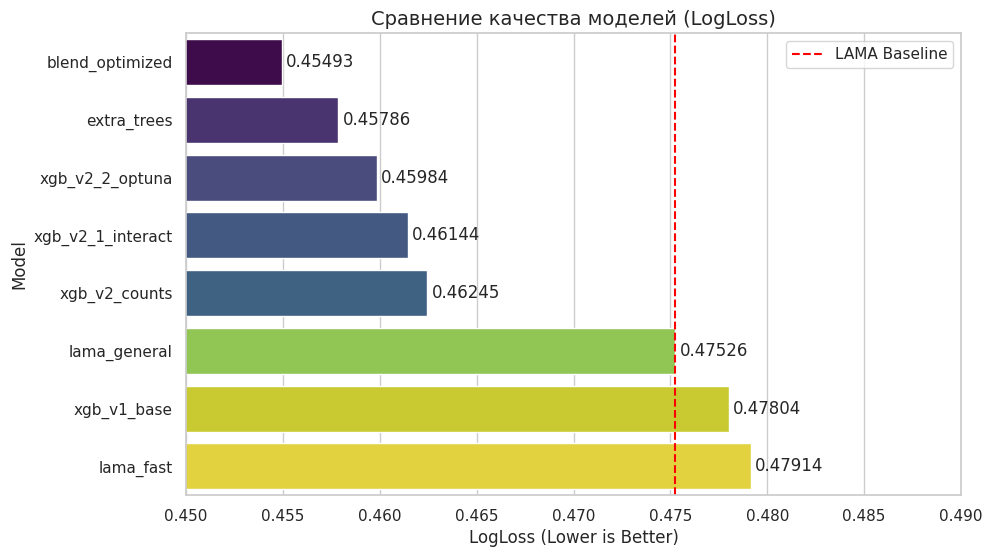

In [20]:
leaderboard = pd.DataFrame(list(LOG_LOSS_SCORES.items()), columns=['Model', 'LogLoss'])

# Сортируем от худшего к лучшему (LogLoss чем меньше, тем лучше)
leaderboard = leaderboard.sort_values(by='LogLoss', ascending=True)

print("=== ИТОГОВЫЙ LEADERBOARD ===")
display(leaderboard)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='LogLoss', hue='LogLoss',  y='Model', data=leaderboard, palette='viridis', legend=False)


for i in ax.containers:
    ax.bar_label(i, fmt='%.5f', padding=3)

plt.title('Сравнение качества моделей (LogLoss)', fontsize=14)
plt.xlabel('LogLoss (Lower is Better)')
plt.xlim(0.45, 0.49) # Масштабируем ось X, чтобы видеть разницу
plt.axvline(x=LOG_LOSS_SCORES['lama_general'], color='red', linestyle='--', label='LAMA Baseline')
plt.legend()
plt.show()

### Итоговое заключение

В рамках данного проекта была поставлена цель: превзойти результаты автоматического ML-решения (LightAutoML) с помощью ручного построения пайплайна, глубокого анализа данных и инженерного подхода.

**Результаты:**
*   **LAMA Baseline:** 0.47526
*   **Best Custom Solution:** 0.45493
*   **Итоговое улучшение:** **~0.02 LogLoss**. В масштабах соревнований Kaggle это весомая разница.

**Ключевые факторы успеха:**

1.  **Глубокий EDA важнее перебора параметров.**
    Простой запуск XGBoost (V1) дал результат хуже, чем LAMA. Однако анализ данных позволил выявить ключевые инсайты: структуру пропусков (`nan_count`) и проблему высокой кардинальности `v22`. Внедрение этих знаний в модель (V2) дало самый резкий скачок качества (**с 0.478 до 0.462**).

2.  **Работа с признаками (Feature Interactions).**
    Гипотеза о скрытых взаимосвязях категориальных признаков подтвердилась. Автоматический поиск пар через *Mutual Information* позволил выжать дополнительную точность там, где одиночные модели уже вышли на плато.

3.  **Правильный выбор архитектуры.**
    Победа **ExtraTrees** над XGBoost в одиночном зачете стала важным открытием. Это подтвердило гипотезу о зашумленности данных: методы с высокой рандомизацией (ET) оказались устойчивее к шуму, чем градиентный бустинг.

4.  **Синергия ансамбля.**
    Финальный блендинг, оптимизированный через `scipy.optimize`, позволил объединить сильные стороны разных семейств алгоритмов, достигнув глобального минимума ошибки (**0.45493**).

**Вывод:**
AutoML - отличный инструмент для получения быстрого и крепкого бейзлайна. Однако профессиональный анализ данных, понимание природы алгоритмов и грамотный Feature Engineering позволяют значительно превзойти автоматические решения, особенно на сложных, "грязных" и анонимизированных данных.

## Финальная проверка на Kaggle Leaderboard

В качестве завершающего этапа все промежуточные и финальные решения были загружены на платформу Kaggle для оценки на отложенной (Private) выборке.

**Скриншот подтверждает корректность выбранной стратегии валидации:**

![Kaggle Leaderboard](images/report.png)
